**chapter4  多层感知机**


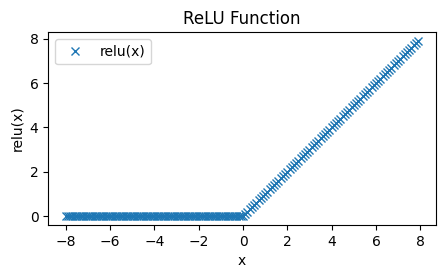

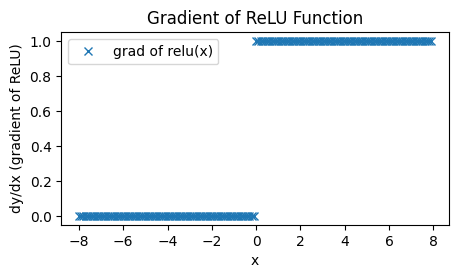

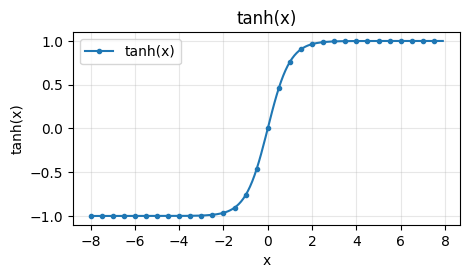

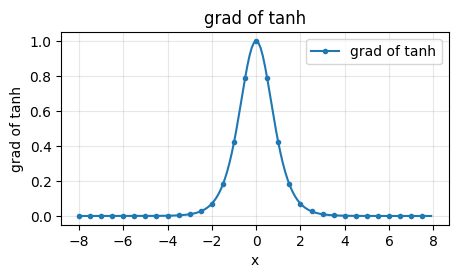

In [21]:
import matplotlib.pyplot as plt
import torch
# 绘制ReLU函数曲线
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
plt.figure(figsize=(5, 2.5))  # 创建画布，宽5、高2.5

# 3. 绘制ReLU函数（修正参数顺序：x, y, 标记样式, label关键字传标签）
# 'x' 表示用“叉号”标记数据点，label用于图例
plt.plot(x.detach(), y.detach(), 'x', label='relu(x)')

# （可选）添加图例、轴标签，让图像更完整
plt.legend()  # 显示图例（对应上面的label）
plt.xlabel('x')  # x轴标签
plt.ylabel('relu(x)')  # y轴标签
plt.title('ReLU Function')  # 图像标题

# 4. 显示图像
plt.show()
y.sum().backward()

# 4. 绘制ReLU的梯度（使用x.grad，且需detach()脱离计算图）
plt.figure(figsize=(5, 2.5))  # 创建画布
# 正确参数：x=x.detach()，y=x.grad.detach()（梯度在x.grad中！）
plt.plot(x.detach(), x.grad.detach(), 'x', label='grad of relu(x)')

# 补充图像细节（可选但推荐）
plt.legend()  # 显示图例
plt.xlabel('x')  # x轴标签
plt.ylabel('dy/dx (gradient of ReLU)')  # y轴标签（明确是梯度）
plt.title('Gradient of ReLU Function')  # 图像标题
plt.show()
def showmap(x=None,y=None,x_label='x',y_label="x.grad",figsize=(5,2.5)):
        plt.figure(figsize=(5, 2.5))  # 创建画布
        # 正确参数：x=x.detach()，y=x.grad.detach()（梯度在x.grad中！）
        plt.plot(x.detach(), y.detach(), 'o-',markersize=3,markevery=5, label=y_label)

        # 补充图像细节（可选但推荐）
        plt.legend()  # 显示图例
        plt.xlabel('x')  # x轴标签
        plt.ylabel(f"{y_label}")  # y轴标签（明确是梯度）
        plt.title(f"{y_label}")
        plt.grid(alpha=0.3)# 图像标题
        plt.show()





x.grad.zero_()  # 清空ReLU的旧梯度，避免干扰
y_tanh = torch.tanh(x)  # 计算tanh函数值

# ① 绘制tanh函数曲线（调用修复后的showmap）
showmap(x=x, y=y_tanh, y_label='tanh(x)')
x.grad.zero_()
y_tanh.sum().backward()
showmap(x=x,y=x.grad,y_label='grad of tanh')
#plt.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))


**4.2.多层感知机从零开始实现**

weight: [[ 3.3156955   0.24761458 -0.24200808  0.34062693]]


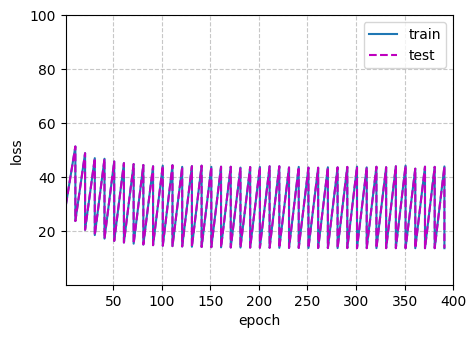

In [14]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Sequential
import math
from d2l.utils import Animator,Accumulator,load_array

def train_epoch_ch3_regression(net, train_iter, loss, optimizer):
    """回归任务的单轮训练函数（自定义，无需从d2l导入）"""
    net.train()  # 切换到训练模式
    metric = Accumulator(2)  # [总损失, 样本数量]
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()  # 清空梯度
        l.mean().backward()    # 反向传播
        optimizer.step()       # 更新参数
        metric.add(l.sum().item(), y.numel())
    return metric[0] / metric[1]  # 平均损失

max_degree=20
n_train,n_test=100,100 #训练数据集和测试数据集
true_w=np.zeros(max_degree)
true_w[0:4]=np.array([5,1.2,-3.4,5.6])

features=np.random.normal(size=(n_test+n_train,1))
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
print("poly_features.shape=",poly_features.shape)
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1) #gamma(n)=(n-1)!
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)
#scale=0.1表示均值为0，标准差为0.1
print("true_w",true_w)
# 定义评估损失的函数
def evaluate_loss(net, data, loss):
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和，样本数量
    for X, y in data:
        y_hat = net(X)
        l = loss(y_hat, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

# 定义训练函数
def train( train_features, test_features, train_labels, test_labels,
          num_epochs=400, learning_rate=0.001, weight_decay=0):
    loss = nn.MSELoss(reduction='none')
    #(y*-y)^2,reduction='mean'返回平方误差的平均值，reduction='sum'返回平方误差的总和。reduction='none'
    #返回每个样本的平方误差，形状与输入一致
    # 不设置bias，因为已经在特征中添加了偏置特征
    net = Sequential(nn.Linear(train_features.shape[-1], 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels), batch_size)
    test_iter = load_array((test_features, test_labels), batch_size,
                               is_train=False)
    # 这里使用Adam优化器，也可以使用SGD等
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    animator = Animator(xlabel='epoch', ylabel='loss', 
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3_regression(net, train_iter, loss, optimizer)
        if epoch % 10 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])



In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Sequential
import math
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time  # 用于控制绘图刷新频率

# -------------------------- 1. 自定义工具类（兼容所有环境） --------------------------
class Accumulator:
    """累加器：统计损失和样本数"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """绘图器：兼容Jupyter和普通Python环境"""
    def __init__(self, xlabel='epoch', ylabel='loss', legend=None, xlim=[1, 400], ylim=[1e-3, 1e2]):
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.legend = legend
        self.xlim = xlim
        self.ylim = ylim
        self.X, self.Y = None, None
        self.fig, self.axes = plt.subplots(figsize=(6, 4))

In [ ]:
%matplotlib inline
import torch
from torch import nn
def synthetic_data(w,b,n_train):
    features=np.random.normal(size=(w.shape[1],))
    np.random.shuffle(features)
    p_features=torch.matmul(w,features)+b

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
train_data =synthetic_data(true_w, true_b, n_train)
test_data =synthetic_data(true_w, true_b, n_test)
train_iter = load_array(train_data, batch_size)
test_iter =load_array(test_data, batch_size, is_train=False)

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2


def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2
def linreg(x,w,b):
    return torch.matmul(x,w)+b
def train(lambd):
    w, b = init_params()
    net = lambda X: linreg(X, w, b)
    loss = lambda y_hat, y: squared_loss(y_hat, y)
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-4, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是:', torch.norm(w).item())

train(lambd=0)
m=torch.normal(0,1,size=(4,4))

ImportError: cannot import name 'synthetic_data' from 'd2l.utils' (/home/pumengyu/2025_9python/limu/d2l/utils.py)

tensor([3.3535e-04, 3.7061e-04, 4.0957e-04, 4.5262e-04, 5.0020e-04, 5.5278e-04,
        6.1088e-04, 6.7508e-04, 7.4603e-04, 8.2442e-04, 9.1105e-04, 1.0068e-03,
        1.1125e-03, 1.2294e-03, 1.3585e-03, 1.5012e-03, 1.6588e-03, 1.8329e-03,
        2.0253e-03, 2.2378e-03, 2.4726e-03, 2.7320e-03, 3.0184e-03, 3.3348e-03,
        3.6842e-03, 4.0701e-03, 4.4963e-03, 4.9668e-03, 5.4863e-03, 6.0598e-03,
        6.6929e-03, 7.3915e-03, 8.1626e-03, 9.0133e-03, 9.9518e-03, 1.0987e-02,
        1.2128e-02, 1.3387e-02, 1.4774e-02, 1.6302e-02, 1.7986e-02, 1.9840e-02,
        2.1881e-02, 2.4127e-02, 2.6597e-02, 2.9312e-02, 3.2295e-02, 3.5571e-02,
        3.9166e-02, 4.3107e-02, 4.7426e-02, 5.2154e-02, 5.7324e-02, 6.2973e-02,
        6.9138e-02, 7.5858e-02, 8.3173e-02, 9.1123e-02, 9.9750e-02, 1.0910e-01,
        1.1920e-01, 1.3011e-01, 1.4185e-01, 1.5447e-01, 1.6798e-01, 1.8243e-01,
        1.9782e-01, 2.1416e-01, 2.3148e-01, 2.4974e-01, 2.6894e-01, 2.8905e-01,
        3.1003e-01, 3.3181e-01, 3.5434e-

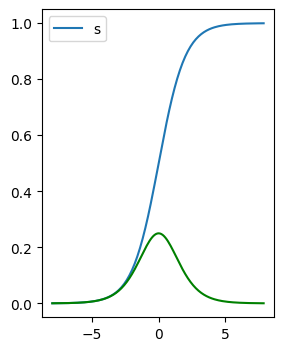

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
x=torch.arange(-8.0,8.0,0.1,requires_grad=True)
y=torch.sigmoid(x)
print(y)
y.backward(torch.ones_like(x))
plt.figure(figsize=(3,4))
plt.plot(x.detach().numpy(),y.detach().numpy())
plt.legend("sigmoid")

plt.plot(x.detach().numpy(),x.grad.numpy(),'-g')
plt.show()

In [4]:
# ========================================
# 1️⃣ Import Library
# ========================================
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#/home/pumengyu/2025_9python/kaggle/input/house-prices-advanced-regression-techniques/train.csv
# ========================================
# 2️⃣ Load Dataset
path=r"/home/pumengyu/2025_9python/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
# ========================================
#train = pd.read_csv('/2025_9python/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
#test = pd.read_csv('/2025_9python/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train=pd.read_csv(path)
test=pd.read_csv(path.replace('train','test'))
train = train[~((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))]
# 2. SalePrice>700000的极端高价样本（超出合理分布）
train = train[train['SalePrice'] <= 700000]
# ========================================
# 3️⃣ Feature Engineering
# ========================================
train_features = train.drop(['Id','SalePrice'], axis=1)
test_features = test.drop(['Id'], axis=1)
print("train_features.shape=",train_features.shape)
print("test_features.shape=",test_features.shape)
print(train_features.columns)
#循环执行两次，第一次df=train_features,第二次df=test_features
#循环直接修改train_features和test_features,没有合并
#当df=train_features时，df['TotalArea']就是train_features['TotalArea'],因为dataframe是可变对象
#可变对象还有字典，列表，DataFrame,不可变对象有整数、字符串，元组
#不想修改原始数据可以，df=df.copy()

for df in [train_features, test_features]:
    df['TotalArea'] = df['GrLivArea'] + df['TotalBsmtSF']
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['OverallQual_GrLivArea'] = df['OverallQual'] * df['GrLivArea']
    df['OverallQual_TotalArea'] = df['OverallQual'] * df['TotalArea']
      # 1. 总功能房间数（卧室+浴室，反映居住舒适度）
    df['TotalRooms'] = df['BedroomAbvGr'] + df['FullBath'] + df['HalfBath'] * 0.5  # 半浴室算0.5
    # 2. 车库与总面积比例（反映车库重要性）
    df['GarageAreaRatio'] = df['GarageArea'] / (df['TotalArea'] + 1)  # +1避免除0
    # 3. 有效房龄（翻新后房龄更反映实际状态，取“建造房龄”和“翻新房龄”的最小值）
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['EffectiveAge'] = df[['HouseAge', 'RemodAge']].min(axis=1)
    # 4. 质量-面积效率（单位面积的质量，反映房屋性价比）
    df['QualPerArea'] = df['OverallQual'] / (df['TotalArea'] + 1)
    # 5. 壁炉数量（反映房屋档次）
    df['FireplaceCount'] = df['Fireplaces'].apply(lambda x: 0 if pd.isna(x) else x)

# ========================================
# 4️⃣ Separate Numeric & Categorical
# ========================================
# Select numeric and categorical columns，只有列的名字，没有带的数值
#.select_dtypes选择数据类型,返回列名和数值，但是加上.columns就只有列名
numeric_cols = train_features.select_dtypes(include=[np.number]).columns
categorical_cols = train_features.select_dtypes(exclude=[np.number]).columns
#log1p(x)=ln(1+x)
y = np.log1p(train['SalePrice'])
print("numeric_cols=",numeric_cols)
for df in [train_features, test_features]:
    # ✅ 有物理意义的缺失值：用“0”或“None”标记“无对应设施”
    # 数值型特征（无设施则为0）
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)  # 无车库→年份0
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)  # 无地下室→面积0
    df['GarageArea'] = df['GarageArea'].fillna(0)    # 无车库→面积0
    # 分类特征（无设施则为None）
    df['GarageType'] = df['GarageType'].fillna('None')  # 无车库→类型None
    df['BsmtQual'] = df['BsmtQual'].fillna('None')      # 无地下室→质量None
    df['FireplaceQu'] = df['FireplaceQu'].fillna('None')# 无壁炉→质量None


# ========================================
# 5️⃣ Handle Missing Values
# ========================================
# Numeric → median
num_imputer = SimpleImputer(strategy='median')
#train_features[numeric_cols]表示取出train_features中所有数值型的列,没有列名ing
#columns=numeric_cols表示重新赋值列名
X_num = pd.DataFrame(num_imputer.fit_transform(train_features[numeric_cols]), columns=numeric_cols)
#下一行用.transform是因为fit_transform是针对训练集的,已经学会了各个列的中位数，可以直接用.
X_test_num = pd.DataFrame(num_imputer.transform(test_features[numeric_cols]), columns=numeric_cols)

# Categorical → most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
X_cat = pd.DataFrame(cat_imputer.fit_transform(train_features[categorical_cols]), columns=categorical_cols)
X_test_cat = pd.DataFrame(cat_imputer.transform(test_features[categorical_cols]), columns=categorical_cols)

# ========================================
# 6️⃣ Encode Categorical
# ========================================
#pd.get_dummies独热编码
#x_test_cat和X_cat列名不一样，需要重新对齐
#x_cat有列的名字
X_cat = pd.get_dummies(X_cat)
X_test_cat = pd.get_dummies(X_test_cat)
X_test_cat = X_test_cat.reindex(columns=X_cat.columns, fill_value=0)

# ========================================
# 7️⃣ Combine Numeric & Categorical
# ========================================
X_clean = pd.concat([X_num, X_cat], axis=1)
X_test_clean = pd.concat([X_test_num, X_test_cat], axis=1)

# ========================================
# 8️⃣ Define Base Models
# ========================================
rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
lgb_model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31, subsample=0.8, colsample_bytree=0.8, random_state=42)

# ========================================
# 9️⃣ Stacking Ensemble
# ========================================
from sklearn.linear_model import Ridge
stack_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('ridge', Ridge(alpha=10,random_state=42))
    ],
    #最终的元学习器，传给它的有三个模型预测的房价和面积等因素，
    final_estimator=LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42),
    cv=5,#cv=5表示5折交叉验证
    n_jobs=-1,#n_jobs=-1表示使用所有可用的CPU核心进行并行计算
    passthrough=True  #passthrough=True表示将原始特征与基模型的预测结果一起传递给最终的元学习器
)

# ========================================
# 🔟 Cross-Validation Check
# ========================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#负均方根误差,cv=kf表示使用kf定义的5折交叉验证，进行五次循环，得到五个评分
#最后取平均作为模型的交叉验证评分
#scoring='neg_root_mean_squared_error'表示使用负均方根误差作为,RMSE=sqrt(mean((y_true-y_pred)^2))
cv_scores = cross_val_score(stack_model, X_clean, y, cv=kf, scoring='neg_root_mean_squared_error')
print("CV RMSE (log):", -cv_scores.mean())
#这个cv_scores是一个包含5个元素的数组，每个元素对应一次交叉验证的评分结果,只用于评价模型的泛化能力

# ========================================
# 1️⃣1️⃣ Fit Stacking Model
# ========================================
#这个stack_model.fit(X_clean, y)会用整个训练集X_clean和y来训练stack_model
#stack_model包含三个基模型和一个元学习器    
#random_state=42保证每次运行结果一致,42是一个常用的随机种子值,无特殊意义
#.fit()会自动由里面的每个模型进行计算误差，梯度更新
stack_model.fit(X_clean, y)

# ========================================
# 1️⃣2️⃣ Predict & Submission
# ========================================
final_preds = stack_model.predict(X_test_clean)
submission = pd.DataFrame({
    "Id": test['Id'],
    "SalePrice": np.expm1(final_preds)
})
submission.to_csv(path.replace('train.csv','submission.csv'), index=False)
#用于显示submission的前5行

submission.head()

train_features.shape= (1456, 79)
test_features.shape= (1459, 79)
Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', '

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4700
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 191
[LightGBM] [Info] Start training from score 12.028422
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 4457
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of data points in the train set: 932, number of used

/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4703
[LightGBM] [Info] Number of data points in the train set: 1165, number of used features: 190
[LightGBM] [Info] Start training from score 12.026970
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Inf

/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4703
[LightGBM] [Info] Number of data points in the train set: 1165, number of used features: 193
[LightGBM] [Info] Start training from score 12.010523
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4702
[LightGBM] [Info] Number of data points in the train set: 1165, number of used features: 192
[LightGBM] [Info] Start training from score 12.025953
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4694
[LightGBM] [Info] Number of data points in the train set: 1165, number of used features: 190
[LightGBM] [Info] Start training from score 12.017887
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


CV RMSE (log): 0.12123162153724218
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4978
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 200
[LightGBM] [Info] Start training from score 12.021950
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002102 seconds.
You can set `force_col_wise=true` to r

/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,Id,SalePrice
0,1461,124873.573842
1,1462,163067.730176
2,1463,188401.009287
3,1464,195626.203554
4,1465,186694.149703


**从豆包得到的house-price竞赛代码，看看结果,环境是dinov3**

In [6]:
import pandas as pd
import numpy as np
# 导入模型选择、评估相关工具
from sklearn.model_selection import KFold, cross_val_score
# 导入数据预处理工具
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
# 导入特征选择工具
from sklearn.feature_selection import RFE
# 导入三大梯度提升树模型（XGBoost、LightGBM、CatBoost）
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
# 导入集成学习工具（Stacking）
from sklearn.ensemble import StackingRegressor
# 导入超参数优化工具Optuna
import optuna
from optuna.samplers import TPESampler
# 导入评估指标（均方根对数误差）
from sklearn.metrics import mean_squared_log_error, make_scorer

# ===================== 1. 数据加载与预处理 =====================
# 加载训练集和测试集
path=r"/home/pumengyu/2025_9python/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
train = pd.read_csv(path)  # 训练集（含房价标签）
test = pd.read_csv(path.replace('train','test'))    # 测试集（无房价标签，需预测）
y_train = np.log1p(train['SalePrice'])      # 提取训练集的房价标签
train = train.drop('SalePrice', axis=1)  # 训练集删除房价标签，仅保留特征
all_data = pd.concat([train, test], axis=0)  # 合并训练和测试集，统一做预处理

# 缺失值处理：分“物理意义缺失”和“统计意义缺失”
# 数值型特征：无对应设施时填0（如无车库则车库面积为0）
for col in ['GarageYrBlt', 'TotalBsmtSF', 'GarageArea']:
    all_data[col] = all_data[col].fillna(0)
# 分类型特征：无对应设施时填'None'（如无地下室则地下室质量为None）
for col in ['GarageType', 'BsmtQual', 'FireplaceQu']:
    all_data[col] = all_data[col].fillna('None')
# 剩余缺失值：数值型填中位数，分类型填最频繁值
num_cols = all_data.select_dtypes(include=['int64', 'float64']).columns  # 筛选数值型列
cat_cols = all_data.select_dtypes(include=['object']).columns            # 筛选分类型列
num_imputer = SimpleImputer(strategy='median')  # 数值型用中位数填充
all_data[num_cols] = num_imputer.fit_transform(all_data[num_cols])
cat_imputer = SimpleImputer(strategy='most_frequent')  # 分类型用最频繁值填充
all_data[cat_cols] = cat_imputer.fit_transform(all_data[cat_cols])

# 类别特征编码：将字符串类别转为数字（模型仅能识别数值）
for col in cat_cols:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col])

# 特征工程：添加交互特征（让模型捕捉特征间的组合关系）
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']  # 总建筑面积
all_data['YearDiff'] = all_data['YrSold'] - all_data['YearBuilt']  # 房屋建成到出售的年限

# 拆分回训练集和测试集
X_train = all_data.iloc[:len(train)]  # 前半部分是训练集特征
X_test = all_data.iloc[len(train):]   # 后半部分是测试集特征


# ===================== 2. 自动化特征选择（减少噪声，提升模型效率） =====================
def select_features(X, y, estimator, n_features=30):
    """
    用RFE（递归特征消除）选择最优特征
    - RFE原理：反复训练模型，删除重要性最低的特征，直到剩余n_features个
    - estimator：用于评估特征重要性的基准模型（这里用XGBoost）
    """
    rfe = RFE(estimator=estimator, n_features_to_select=n_features, step=1)
    rfe.fit(X, y)
    selected_cols = X.columns[rfe.support_]  # 筛选被选中的特征列
    return selected_cols

# 用XGBoost作为基准模型，选择35个最具预测力的特征
base_estimator = XGBRegressor(random_state=42)
selected_cols = select_features(X_train, y_train, base_estimator, n_features=35)
X_train_selected = X_train[selected_cols]  # 训练集仅保留选中的特征
X_test_selected = X_test[selected_cols]    # 测试集同步保留选中的特征
# 1. 检查训练集特征（X_train_selected）是否有 NaN 或 无穷值
print("X_train_selected 缺失值数量：", X_train_selected.isnull().sum().sum())
print("X_train_selected 无穷值数量：", np.isinf(X_train_selected).sum().sum())

# 2. 检查目标变量（y_train）是否有异常值（如 0 或极大值，房价不可能为 0）
print("y_train 最小值：", y_train.min())
print("y_train 最大值：", y_train.max())
print("y_train 缺失值数量：", y_train.isnull().sum())

# ===================== 3. 超参数优化（Optuna自动搜索最优参数） =====================
def objective(trial, X, y, model_name):
    """
    Optuna的目标函数：为不同模型搜索最优超参数
    - trial：Optuna的试错对象，用于采样超参数
    - model_name：区分XGBoost、LightGBM、CatBoost
    - 返回值：模型在交叉验证中的平均RMSLE（越小越好）
    """
    try:
        if model_name == 'xgb':
            # 为XGBoost定义超参数搜索范围
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),  # 树的数量
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # 学习率
                'max_depth': trial.suggest_int('max_depth', 3, 10),  # 树的最大深度
                'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # 样本抽样比例
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # 特征抽样比例
                'random_state': 42
            }
            model = XGBRegressor(**params)
        elif model_name == 'lgb':
            # 为LightGBM定义超参数搜索范围
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
                'random_state': 42
            }
            model = LGBMRegressor(**params)
        elif model_name == 'cat':
            # 为CatBoost定义超参数搜索范围
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'depth': trial.suggest_int('depth', 3, 10),  # CatBoost用depth表示树深度
                'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                'random_state': 42,
                'silent': True  # 静默模式，不打印训练日志
            }
            model = CatBoostRegressor(**params)
        
        # 5折交叉验证，评估模型性能
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        rmsle_scorer = make_scorer(mean_squared_log_error, squared=False)  # 定义RMSLE评分器
        scores = cross_val_score(model, X, y, cv=kf, scoring=rmsle_scorer)
        return scores.mean()  # 返回交叉验证的平均分数
    except Exception as e:
        print(f"Error in trial {trial.number} for model {model_name}: {e}")
        print(f"Trial {trial.number} 失败！错误原因：{str(e)}")
        # 返回一个极大值，标记该 trial 为差解
        return float('inf')
        return float('inf')  # 出错时返回无穷大，表示该参数组合不可行

# 优化XGBoost的超参数（迭代50次，寻找最优解）
xgb_study = optuna.create_study(sampler=TPESampler(seed=42), direction='minimize')
xgb_study.optimize(lambda trial: objective(trial, X_train_selected, y_train, 'xgb'), n_trials=50)
xgb_best = XGBRegressor(**xgb_study.best_params)  # 实例化最优XGBoost模型

# 优化LightGBM的超参数
lgb_study = optuna.create_study(sampler=TPESampler(seed=42), direction='minimize')
lgb_study.optimize(lambda trial: objective(trial, X_train_selected, y_train, 'lgb'), n_trials=50)
lgb_best = LGBMRegressor(**lgb_study.best_params)  # 实例化最优LightGBM模型

# 优化CatBoost的超参数
cat_study = optuna.create_study(sampler=TPESampler(seed=42), direction='minimize')
cat_study.optimize(lambda trial: objective(trial, X_train_selected, y_train, 'cat'), n_trials=50)
cat_best = CatBoostRegressor(**cat_study.best_params, silent=True)  # 实例化最优CatBoost模型


# ===================== 4. 多模型融合（Stacking，整合多个模型的优势） =====================
# 定义基学习器（三个不同类型的梯度提升树模型）
estimators = [
    ('xgb', xgb_best),   # 标签'xgb'对应最优XGBoost
    ('lgb', lgb_best),   # 标签'lgb'对应最优LightGBM
    ('cat', cat_best)    # 标签'cat'对应最优CatBoost
]
# 定义元学习器（用最优LightGBM来融合基学习器的预测结果）
final_estimator = LGBMRegressor(**lgb_study.best_params)
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,  # 5折交叉验证生成基学习器的预测
    n_jobs=-1  # 使用所有CPU核心加速训练
)

# 训练Stacking模型 & 预测测试集
stack_model.fit(X_train_selected, y_train)  # 用训练集特征和标签训练
y_pred = stack_model.predict(X_test_selected)  # 对测试集特征预测房价
y_pred=np.expm1(y_pred)  # 反对数转换，恢复原始房价
# 生成Kaggle提交文件
submission = pd.DataFrame({
    'Id': test['Id'],       # 测试集的房屋ID
    'SalePrice': y_pred     # 预测的房价
})
submission.to_csv('submission.csv', index=False)  # 保存为CSV，用于Kaggle提交

[I 2025-09-25 15:44:47,012] A new study created in memory with name: no-name-a9685500-a30a-4969-aeac-db5b31818745


X_train_selected 缺失值数量： 0
X_train_selected 无穷值数量： 0
y_train 最小值： 10.460270761075149
y_train 最大值： 13.534474352733596
y_train 缺失值数量： 0


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

ValueError: No trials are completed yet.

In [13]:
import pandas as pd
import numpy as np
import json
import logging
from datetime import datetime

# 配置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("training.log"),
        logging.StreamHandler()
    ]
)

# 导入模型选择、评估相关工具
from sklearn.model_selection import KFold, cross_val_score
# 导入数据预处理工具
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
# 导入特征选择工具
from sklearn.feature_selection import RFE
# 导入三大梯度提升树模型
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
# 导入集成学习工具
from sklearn.ensemble import StackingRegressor
# 导入超参数优化工具Optuna（适配4.5.0版本）
import optuna
from optuna.samplers import TPESampler
# 导入评估指标
from sklearn.metrics import mean_squared_log_error, make_scorer

def main():
    try:
        logging.info("开始房价预测模型训练流程")
        start_time = datetime.now()
        
        # ===================== 1. 数据加载与预处理 =====================
        logging.info("加载并预处理数据")
        path = r"/home/pumengyu/2025_9python/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
        train = pd.read_csv(path)
        test = pd.read_csv(path.replace('train','test'))
        
        # 保存测试集ID用于最终提交
        test_id = test['Id'].copy()
        
        # 删除Id列（无关特征）
        train = train.drop('Id', axis=1)
        test = test.drop('Id', axis=1)
        
        # 提取并转换目标变量
        y_train = np.log1p(train['SalePrice'])
        train = train.drop('SalePrice', axis=1)
        
        # 合并数据集进行统一预处理
        all_data = pd.concat([train, test], axis=0, ignore_index=True)
        logging.info(f"合并后的数据形状: {all_data.shape}")
        
        # 缺失值处理
        logging.info("处理缺失值")
        # 数值型特征：无对应设施时填0
        for col in ['GarageYrBlt', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea']:
            if col in all_data.columns:
                all_data[col] = all_data[col].fillna(0)
        
        # 分类型特征：无对应设施时填'None'
        for col in ['GarageType', 'BsmtQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
            if col in all_data.columns:
                all_data[col] = all_data[col].fillna('None')
        
        # 剩余缺失值：数值型填中位数，分类型填最频繁值
        num_cols = all_data.select_dtypes(include=['int64', 'float64']).columns
        cat_cols = all_data.select_dtypes(include=['object']).columns
        
        logging.info(f"数值型特征数量: {len(num_cols)}, 分类型特征数量: {len(cat_cols)}")
        
        # 填充数值型缺失值
        num_imputer = SimpleImputer(strategy='median')
        all_data[num_cols] = num_imputer.fit_transform(all_data[num_cols])
        
        # 填充分类型缺失值
        cat_imputer = SimpleImputer(strategy='most_frequent')
        all_data[cat_cols] = cat_imputer.fit_transform(all_data[cat_cols])
        
        # 类别特征编码
        logging.info("编码分类型特征")
        for col in cat_cols:
            le = LabelEncoder()
            # 处理可能的新类别
            all_data[col] = le.fit_transform(all_data[col].astype(str))
        
        # 特征工程
        logging.info("创建新特征")
        # 总建筑面积
        all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
        all_data['TotalSF'] = all_data['TotalSF'].clip(lower=0)  # 确保非负
        
        # 房屋年龄
        all_data['YearDiff'] = all_data['YrSold'] - all_data['YearBuilt']
        all_data['YearDiff'] = all_data['YearDiff'].clip(lower=0)  # 确保非负
        
        # 总浴室数
        if all_data.columns.isin(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']).all():
            all_data['TotalBath'] = all_data['FullBath'] + 0.5 * all_data['HalfBath'] + all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath']
        
        # 拆分回训练集和测试集
        X_train = all_data.iloc[:len(train)]
        X_test = all_data.iloc[len(train):]
        
        # 数据验证
        logging.info("验证数据质量")
        logging.info(f"训练集缺失值数量: {X_train.isnull().sum().sum()}")
        logging.info(f"测试集缺失值数量: {X_test.isnull().sum().sum()}")
        logging.info(f"训练集无穷值数量: {np.isinf(X_train).sum().sum()}")
        logging.info(f"测试集无穷值数量: {np.isinf(X_test).sum().sum()}")
        logging.info(f"目标变量最小值: {y_train.min()}, 最大值: {y_train.max()}, 缺失值: {y_train.isnull().sum()}")
        
        # 确保没有缺失值或无穷值
        assert X_train.isnull().sum().sum() == 0, "训练集仍有缺失值"
        assert X_test.isnull().sum().sum() == 0, "测试集仍有缺失值"
        assert np.isinf(X_train).sum().sum() == 0, "训练集仍有无穷值"
        assert np.isinf(X_test).sum().sum() == 0, "测试集仍有无穷值"
        assert not y_train.isnull().any(), "目标变量仍有缺失值"
        
        # ===================== 2. 特征选择 =====================
        logging.info("进行特征选择")
        def select_features(X, y, estimator, n_features=30):
            try:
                rfe = RFE(estimator=estimator, n_features_to_select=n_features, step=1)
                rfe.fit(X, y)
                return X.columns[rfe.support_]
            except Exception as e:
                logging.error(f"特征选择失败: {str(e)}")
                # 失败时返回所有特征
                return X.columns
        
        # 使用简单的XGBoost模型进行特征选择
        base_estimator = XGBRegressor(
            n_estimators=100,
            max_depth=5,
            random_state=42,
            verbosity=0
        )
        
        selected_cols = select_features(X_train, y_train, base_estimator, n_features=35)
        X_train_selected = X_train[selected_cols]
        X_test_selected = X_test[selected_cols]
        
        logging.info(f"选择的特征数量: {len(selected_cols)}")
        logging.info(f"选择的特征: {', '.join(selected_cols)}")
        
        # ===================== 3. 超参数优化（适配Optuna 4.5.0） =====================
        logging.info("开始超参数优化")
        
        # Optuna 4.x版本：通过全局日志设置控制输出（替代verbosity参数）
        optuna.logging.set_verbosity(optuna.logging.INFO)  # INFO级别会显示试验进度
        
        def objective(trial, X, y, model_name):
            try:
                logging.info(f"开始试验 {trial.number} 用于模型 {model_name}")
                
                if model_name == 'xgb':
                    params = {
                        'objective': 'reg:squarederror',
                        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                        'max_depth': trial.suggest_int('max_depth', 3, 7),
                        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
                        'random_state': 42,
                        'verbosity': 0
                    }
                    model = XGBRegressor(** params)
                
                elif model_name == 'lgb':
                    params = {
                        'objective': 'regression',
                        'metric': 'rmse',
                        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                        'max_depth': trial.suggest_int('max_depth', 3, 7),
                        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
                        'random_state': 42,
                        'verbose': -1
                    }
                    model = LGBMRegressor(**params)
                
                elif model_name == 'cat':
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                        'depth': trial.suggest_int('depth', 3, 7),
                        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                        'random_state': 42,
                        'silent': True
                    }
                    model = CatBoostRegressor(** params)
                
                # 使用3折交叉验证加速
                kf = KFold(n_splits=3, shuffle=True, random_state=42)
                rmsle_scorer = make_scorer(mean_squared_log_error, squared=False)
                
                # 限制单次交叉验证时间
                scores = cross_val_score(
                    model, X, y, cv=kf, scoring=rmsle_scorer, 
                    n_jobs=1,  # 使用单线程避免冲突
                    verbose=0
                )
                
                mean_score = scores.mean()
                logging.info(f"试验 {trial.number} 完成，分数: {mean_score:.4f}")
                return mean_score
                
            except Exception as e:
                error_msg = f"试验 {trial.number} 失败: {str(e)}"
                logging.error(error_msg)
                return float('inf')
        
        # 优化XGBoost（先尝试少量试验）
        logging.info("优化XGBoost超参数")
        xgb_study = optuna.create_study(
            sampler=TPESampler(seed=42), 
            direction='minimize'  # 移除verbosity参数（Optuna 4.x不支持）
        )
        
        # 先尝试5次试验，确认是否能成功
        xgb_study.optimize(
            lambda trial: objective(trial, X_train_selected, y_train, 'xgb'),
            n_trials=5,
            show_progress_bar=True  # Optuna 4.x支持进度条
        )
        
        # 检查是否有完成的试验
        completed_trials = [t for t in xgb_study.trials if t.state == optuna.trial.TrialState.COMPLETE]
        logging.info(f"XGBoost完成的试验数量: {len(completed_trials)}/{len(xgb_study.trials)}")
        
        if not completed_trials:
            logging.warning("XGBoost没有完成任何试验，使用默认参数")
            xgb_best = XGBRegressor(random_state=42)
        else:
            # 如果有完成的试验，继续优化到50次
            xgb_study.optimize(
                lambda trial: objective(trial, X_train_selected, y_train, 'xgb'),
                n_trials=45,  # 已经完成了5次
                show_progress_bar=True
            )
            xgb_best = XGBRegressor(** xgb_study.best_params)
            with open('xgb_best_params.json', 'w') as f:
                json.dump(xgb_study.best_params, f, indent=4)
        
        # 优化LightGBM
        logging.info("优化LightGBM超参数")
        lgb_study = optuna.create_study(
            sampler=TPESampler(seed=42), 
            direction='minimize'
        )
        
        lgb_study.optimize(
            lambda trial: objective(trial, X_train_selected, y_train, 'lgb'),
            n_trials=50,
            show_progress_bar=True
        )
        
        completed_trials = [t for t in lgb_study.trials if t.state == optuna.trial.TrialState.COMPLETE]
        if not completed_trials:
            logging.warning("LightGBM没有完成任何试验，使用默认参数")
            lgb_best = LGBMRegressor(random_state=42)
        else:
            lgb_best = LGBMRegressor(**lgb_study.best_params)
            with open('lgb_best_params.json', 'w') as f:
                json.dump(lgb_study.best_params, f, indent=4)
        
        # 优化CatBoost
        logging.info("优化CatBoost超参数")
        cat_study = optuna.create_study(
            sampler=TPESampler(seed=42), 
            direction='minimize'
        )
        
        cat_study.optimize(
            lambda trial: objective(trial, X_train_selected, y_train, 'cat'),
            n_trials=50,
            show_progress_bar=True
        )
        
        completed_trials = [t for t in cat_study.trials if t.state == optuna.trial.TrialState.COMPLETE]
        if not completed_trials:
            logging.warning("CatBoost没有完成任何试验，使用默认参数")
            cat_best = CatBoostRegressor(random_state=42, silent=True)
        else:
            cat_best = CatBoostRegressor(** cat_study.best_params, silent=True)
            with open('cat_best_params.json', 'w') as f:
                json.dump(cat_study.best_params, f, indent=4)
        
        # ===================== 4. 模型融合 =====================
        logging.info("训练Stacking模型")
        estimators = [
            ('xgb', xgb_best),
            ('lgb', lgb_best),
            ('cat', cat_best)
        ]
        
        # 使用默认参数的元学习器，避免再次出现问题
        final_estimator = LGBMRegressor(random_state=42)
        
        stack_model = StackingRegressor(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=3,  # 减少折数加速训练
            n_jobs=-1
        )
        
        stack_model.fit(X_train_selected, y_train)
        
        # ===================== 5. 预测与提交 =====================
        logging.info("生成预测结果")
        y_pred = stack_model.predict(X_test_selected)
        y_pred = np.expm1(y_pred)  # 还原为原始房价
        
        # 生成提交文件
        submission = pd.DataFrame({
            'Id': test_id,
            'SalePrice': y_pred
        })
        submission.to_csv('submission.csv', index=False)
        logging.info("提交文件已保存为 submission.csv")
        submission.head()
        end_time = datetime.now()
        logging.info(f"训练完成，总耗时: {end_time - start_time}")
        
    except Exception as e:
        logging.error(f"整个流程失败: {str(e)}", exc_info=True)
        raise

if __name__ == "__main__":
    main()



2025-09-25 16:05:39,284 - INFO - 开始房价预测模型训练流程
2025-09-25 16:05:39,284 - INFO - 加载并预处理数据
2025-09-25 16:05:39,303 - INFO - 合并后的数据形状: (2919, 79)
2025-09-25 16:05:39,303 - INFO - 处理缺失值
2025-09-25 16:05:39,309 - INFO - 数值型特征数量: 36, 分类型特征数量: 43


2025-09-25 16:05:39,332 - INFO - 编码分类型特征
2025-09-25 16:05:39,351 - INFO - 创建新特征
2025-09-25 16:05:39,353 - INFO - 验证数据质量
2025-09-25 16:05:39,355 - INFO - 训练集缺失值数量: 0
2025-09-25 16:05:39,357 - INFO - 测试集缺失值数量: 0
2025-09-25 16:05:39,358 - INFO - 训练集无穷值数量: 0
2025-09-25 16:05:39,360 - INFO - 测试集无穷值数量: 0
2025-09-25 16:05:39,361 - INFO - 目标变量最小值: 10.460270761075149, 最大值: 13.534474352733596, 缺失值: 0
2025-09-25 16:05:39,367 - INFO - 进行特征选择
2025-09-25 16:05:42,507 - INFO - 选择的特征数量: 35
2025-09-25 16:05:42,507 - INFO - 选择的特征: MSZoning, LotArea, LandContour, Neighborhood, Condition2, OverallQual, OverallCond, YearBuilt, YearRemodAdd, ExterCond, BsmtQual, BsmtFinSF1, BsmtUnfSF, CentralAir, 2ndFlrSF, GrLivArea, BsmtHalfBath, FullBath, HalfBath, KitchenAbvGr, KitchenQual, Functional, Fireplaces, GarageType, GarageYrBlt, GarageCars, GarageArea, GarageCond, PavedDrive, EnclosedPorch, ScreenPorch, PoolArea, SaleCondition, TotalSF, YearDiff
2025-09-25 16:05:42,508 - INFO - 开始超参数优化
2025-09-25 16:05:42,508 -

  0%|          | 0/5 [00:00<?, ?it/s]

2025-09-25 16:05:42,513 - INFO - 开始试验 0 用于模型 xgb
/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/p

[W 2025-09-25 16:05:43,046] Trial 0 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.17254716573280354, 'max_depth': 6, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:43,046] Trial 0 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:43,542] Trial 1 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.011900590783184251, 'max_depth': 7, 'subsample': 0.8803345035229626, 'colsample_bytree': 0.9124217733388136} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:43,542] Trial 1 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:43,840] Trial 2 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.18276027831785724, 'max_depth': 7, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:43,840] Trial 2 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:44,120] Trial 3 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.024878734419814436, 'max_depth': 5, 'subsample': 0.8295835055926347, 'colsample_bytree': 0.7873687420594125} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:44,121] Trial 3 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:44,605] Trial 4 failed with parameters: {'n_estimators': 350, 'learning_rate': 0.01518747922672247, 'max_depth': 4, 'subsample': 0.8099085529881075, 'colsample_bytree': 0.8368209952651108} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:44,606] Trial 4 failed with value np.float64(nan).


  0%|          | 0/50 [00:00<?, ?it/s]

2025-09-25 16:05:44,612 - INFO - 开始试验 0 用于模型 lgb
/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/p

[W 2025-09-25 16:05:44,743] Trial 0 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.17254716573280354, 'max_depth': 6, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:44,743] Trial 0 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:44,904] Trial 1 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.011900590783184251, 'max_depth': 7, 'subsample': 0.8803345035229626, 'colsample_bytree': 0.9124217733388136} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:44,904] Trial 1 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:44,977] Trial 2 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.18276027831785724, 'max_depth': 7, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:44,977] Trial 2 failed with value np.float64(nan).
[W 2025-09-25 16:05:45,081] Trial 3 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.024878734419814436, 'max_depth': 5, 'subsample': 0.8295835055926347, 'colsample_bytree': 0.7873687420594125} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:45,081] Trial 3 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:45,238] Trial 4 failed with parameters: {'n_estimators': 350, 'learning_rate': 0.01518747922672247, 'max_depth': 4, 'subsample': 0.8099085529881075, 'colsample_bytree': 0.8368209952651108} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:45,238] Trial 4 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:45,464] Trial 5 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.018187859051288217, 'max_depth': 5, 'subsample': 0.8777243706586128, 'colsample_bytree': 0.7139351238159993} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:45,464] Trial 5 failed with value np.float64(nan).
[W 2025-09-25 16:05:45,573] Trial 6 failed with parameters: {'n_estimators': 350, 'learning_rate': 0.016666983286066417, 'max_depth': 3, 'subsample': 0.984665661176, 'colsample_bytree': 0.9896896099223678} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:45,574] Trial 6 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:45,699] Trial 7 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.0249064396938244, 'max_depth': 3, 'subsample': 0.905269907953647, 'colsample_bytree': 0.8320457481218804} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:45,699] Trial 7 failed with value np.float64(nan).
[W 2025-09-25 16:05:45,755] Trial 8 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.04407984038169244, 'max_depth': 3, 'subsample': 0.9727961206236346, 'colsample_bytree': 0.777633994480005} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:45,756] Trial 8 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:45,931] Trial 9 failed with parameters: {'n_estimators': 350, 'learning_rate': 0.02544166090938368, 'max_depth': 5, 'subsample': 0.8640130838029838, 'colsample_bytree': 0.7554563366576581} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:45,931] Trial 9 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:46,209] Trial 10 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.10196967939171485, 'max_depth': 7, 'subsample': 0.9684482051282947, 'colsample_bytree': 0.8793699936433255} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:46,209] Trial 10 failed with value np.float64(nan).
[W 2025-09-25 16:05:46,354] Trial 11 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.01303561122512888, 'max_depth': 3, 'subsample': 0.7135681866731614, 'colsample_bytree': 0.7975990992289793} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:46,355] Trial 11 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:46,553] Trial 12 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.022544116997360492, 'max_depth': 7, 'subsample': 0.8070259980080767, 'colsample_bytree': 0.7842803529062142} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:46,553] Trial 12 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:46,810] Trial 13 failed with parameters: {'n_estimators': 300, 'learning_rate': 0.015252697030515175, 'max_depth': 7, 'subsample': 0.7223651931039312, 'colsample_bytree': 0.9960660809801551} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:46,810] Trial 13 failed with value np.float64(nan).
[W 2025-09-25 16:05:46,928] Trial 14 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.018135730867783396, 'max_depth': 3, 'subsample': 0.9446384285364502, 'colsample_bytree': 0.9120572031542851} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:46,929] Trial 14 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:47,038] Trial 15 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.10079659367870726, 'max_depth': 3, 'subsample': 0.8075397185632818, 'colsample_bytree': 0.7347607178575388} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:47,038] Trial 15 failed with value np.float64(nan).
[W 2025-09-25 16:05:47,190] Trial 16 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.06470376604234768, 'max_depth': 4, 'subsample': 0.7190675050858071, 'colsample_bytree': 0.7932946965146986} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:47,190] Trial 16 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:47,304] Trial 17 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.08896916672592671, 'max_depth': 6, 'subsample': 0.9661638227728979, 'colsample_bytree': 0.8416644775485848} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:47,305] Trial 17 failed with value np.float64(nan).
[W 2025-09-25 16:05:47,399] Trial 18 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.08471354625326555, 'max_depth': 6, 'subsample': 0.8683831592708489, 'colsample_bytree': 0.9312901539863683} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:47,399] Trial 18 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:47,539] Trial 19 failed with parameters: {'n_estimators': 300, 'learning_rate': 0.04787304927324382, 'max_depth': 5, 'subsample': 0.7076257380232285, 'colsample_bytree': 0.7323674280979913} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:47,539] Trial 19 failed with value np.float64(nan).
[W 2025-09-25 16:05:47,595] Trial 20 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.06729596646792112, 'max_depth': 4, 'subsample': 0.8525712073494108, 'colsample_bytree': 0.9722699421778279} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:47,595] Trial 20 failed with value np.float64(nan).
[W 2025-09-25 16:05:47,733] Trial 21 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.03419168411765895, 'max_depth': 6, 'subsample': 0.7686394496474867, 'colsample_bytree': 0.7230939729486379} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:47,733] Tri

/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:47,926] Trial 22 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.01620890700720353, 'max_depth': 7, 'subsample': 0.9424361138693251, 'colsample_bytree': 0.8900211269531271} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:47,926] Trial 22 failed with value np.float64(nan).
[W 2025-09-25 16:05:48,044] Trial 23 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.11107120377605907, 'max_depth': 3, 'subsample': 0.9677676995469933, 'colsample_bytree': 0.8618026725746952} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:48,044] Trial 23 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:48,199] Trial 24 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.146501361250436, 'max_depth': 4, 'subsample': 0.733015577358303, 'colsample_bytree': 0.7683805487625824} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:48,199] Trial 24 failed with value np.float64(nan).
[W 2025-09-25 16:05:48,349] Trial 25 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.11594759566372474, 'max_depth': 7, 'subsample': 0.7020856391593572, 'colsample_bytree': 0.8532241907732697} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:48,350] Trial 25 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:48,435] Trial 26 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.019452208847287395, 'max_depth': 3, 'subsample': 0.8012845514210883, 'colsample_bytree': 0.9828729111737557} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:48,435] Trial 26 failed with value np.float64(nan).
[W 2025-09-25 16:05:48,563] Trial 27 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.047311003556264795, 'max_depth': 6, 'subsample': 0.8090888807137881, 'colsample_bytree': 0.9915346248162882} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:48,563] Trial 27 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:48,798] Trial 28 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.021260639289175844, 'max_depth': 5, 'subsample': 0.7902634929450308, 'colsample_bytree': 0.7854521483132403} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:48,798] Trial 28 failed with value np.float64(nan).
[W 2025-09-25 16:05:48,869] Trial 29 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.062095693648805635, 'max_depth': 5, 'subsample': 0.7154436253749967, 'colsample_bytree': 0.7835939392709834} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:48,869] Trial 29 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:49,008] Trial 30 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.020496381951116718, 'max_depth': 3, 'subsample': 0.8468358280832688, 'colsample_bytree': 0.9956951362331803} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:49,009] Trial 30 failed with value np.float64(nan).
[W 2025-09-25 16:05:49,144] Trial 31 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.07489770465258357, 'max_depth': 6, 'subsample': 0.7712912631977199, 'colsample_bytree': 0.9184649045835579} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:49,144] Trial 31 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:49,291] Trial 32 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.06647354682787941, 'max_depth': 6, 'subsample': 0.8607324052224276, 'colsample_bytree': 0.7270869310163225} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:49,291] Trial 32 failed with value np.float64(nan).
[W 2025-09-25 16:05:49,416] Trial 33 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.0261423416776307, 'max_depth': 3, 'subsample': 0.7122325424664291, 'colsample_bytree': 0.8772678829564725} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:49,417] Trial 33 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:49,659] Trial 34 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.010509480845860123, 'max_depth': 5, 'subsample': 0.7679487325593813, 'colsample_bytree': 0.8935518371228349} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:49,659] Trial 34 failed with value np.float64(nan).
[W 2025-09-25 16:05:49,726] Trial 35 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.07923749226909173, 'max_depth': 4, 'subsample': 0.9810189966210203, 'colsample_bytree': 0.7412562832437979} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:49,727] Trial 35 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:49,954] Trial 36 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.014048580838867042, 'max_depth': 7, 'subsample': 0.9632018060142943, 'colsample_bytree': 0.7773824883145466} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:49,954] Trial 36 failed with value np.float64(nan).
[W 2025-09-25 16:05:50,103] Trial 37 failed with parameters: {'n_estimators': 350, 'learning_rate': 0.11567262614299902, 'max_depth': 5, 'subsample': 0.8588951735068019, 'colsample_bytree': 0.7725556872701355} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:50,104] Trial 37 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:50,177] Trial 38 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.14699569423568365, 'max_depth': 7, 'subsample': 0.8899304371819804, 'colsample_bytree': 0.8017089373146101} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:50,177] Trial 38 failed with value np.float64(nan).
[W 2025-09-25 16:05:50,329] Trial 39 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.08800150788211335, 'max_depth': 7, 'subsample': 0.9661259272795352, 'colsample_bytree': 0.9339626637572871} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:50,330] Trial 39 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:50,440] Trial 40 failed with parameters: {'n_estimators': 350, 'learning_rate': 0.012866742758077603, 'max_depth': 3, 'subsample': 0.9695662565581238, 'colsample_bytree': 0.881928717897877} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:50,440] Trial 40 failed with value np.float64(nan).
[W 2025-09-25 16:05:50,542] Trial 41 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.013552440865865809, 'max_depth': 6, 'subsample': 0.7015184751538656, 'colsample_bytree': 0.7482424154252496} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:50,542] Trial 41 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:50,715] Trial 42 failed with parameters: {'n_estimators': 300, 'learning_rate': 0.0794650948407619, 'max_depth': 6, 'subsample': 0.7672807928381679, 'colsample_bytree': 0.9136537664042608} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:50,715] Trial 42 failed with value np.float64(nan).
[W 2025-09-25 16:05:50,863] Trial 43 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.026506645379019665, 'max_depth': 6, 'subsample': 0.8948898697141644, 'colsample_bytree': 0.9547670231482533} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:50,863] Trial 43 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:50,960] Trial 44 failed with parameters: {'n_estimators': 350, 'learning_rate': 0.05487651709243168, 'max_depth': 3, 'subsample': 0.8103147409178301, 'colsample_bytree': 0.7795607103045176} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:50,961] Trial 44 failed with value np.float64(nan).
[W 2025-09-25 16:05:51,037] Trial 45 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.184465824705519, 'max_depth': 4, 'subsample': 0.967613966553134, 'colsample_bytree': 0.8893415877991788} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:51,038] Trial 45 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:51,230] Trial 46 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.04507605862608787, 'max_depth': 5, 'subsample': 0.8477553081456591, 'colsample_bytree': 0.7585728963394133} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:51,230] Trial 46 failed with value np.float64(nan).
[W 2025-09-25 16:05:51,347] Trial 47 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.023189600426122402, 'max_depth': 3, 'subsample': 0.8936416887721503, 'colsample_bytree': 0.7531332038221147} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:51,347] Trial 47 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:51,640] Trial 48 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.17421666361361082, 'max_depth': 7, 'subsample': 0.8110476100766333, 'colsample_bytree': 0.7046369849586602} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:51,641] Trial 48 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:51,937] Trial 49 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.036064541947720755, 'max_depth': 7, 'subsample': 0.9890859931267759, 'colsample_bytree': 0.955902836640208} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:51,937] Trial 49 failed with value np.float64(nan).


  0%|          | 0/50 [00:00<?, ?it/s]

2025-09-25 16:05:51,945 - INFO - 开始试验 0 用于模型 cat
/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/p

[W 2025-09-25 16:05:52,384] Trial 0 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.17254716573280354, 'depth': 6, 'subsample': 0.8795975452591109} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:52,384] Trial 0 failed with value np.float64(nan).
[W 2025-09-25 16:05:52,535] Trial 1 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.015957084694148364, 'depth': 3, 'subsample': 0.9598528437324805} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:52,536] Trial 1 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:52,814] Trial 2 failed with parameters: {'n_estimators': 350, 'learning_rate': 0.08341106432362087, 'depth': 3, 'subsample': 0.9909729556485982} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:52,815] Trial 2 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:53,179] Trial 3 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.018891200276189388, 'depth': 3, 'subsample': 0.7550213529560301} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:53,179] Trial 3 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:53,452] Trial 4 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.048164145309070844, 'depth': 5, 'subsample': 0.7873687420594125} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:53,453] Trial 4 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:53,812] Trial 5 failed with parameters: {'n_estimators': 350, 'learning_rate': 0.01518747922672247, 'depth': 4, 'subsample': 0.8099085529881075} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:53,812] Trial 5 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:54,064] Trial 6 failed with parameters: {'n_estimators': 300, 'learning_rate': 0.10508421338691762, 'depth': 3, 'subsample': 0.8542703315240835} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:54,065] Trial 6 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:54,660] Trial 7 failed with parameters: {'n_estimators': 350, 'learning_rate': 0.011492999300221412, 'depth': 6, 'subsample': 0.7511572371061874} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:54,661] Trial 7 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:54,940] Trial 8 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.17160445029754812, 'depth': 7, 'subsample': 0.9425192044349383} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:54,940] Trial 8 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:55,376] Trial 9 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.013399060561509796, 'depth': 6, 'subsample': 0.8320457481218804} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:55,377] Trial 9 failed with value np.float64(nan).
[W 2025-09-25 16:05:55,522] Trial 10 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.04407984038169244, 'depth': 3, 'subsample': 0.9727961206236346} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:55,522] Trial 10 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:55,750] Trial 11 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.07277150634170934, 'depth': 4, 'subsample': 0.8560204063533432} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:55,751] Trial 11 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:56,649] Trial 12 failed with parameters: {'n_estimators': 300, 'learning_rate': 0.017398074711291726, 'depth': 7, 'subsample': 0.9325398470083344} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:56,650] Trial 12 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:57,273] Trial 13 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.1459476894296684, 'depth': 5, 'subsample': 0.976562270506935} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:57,274] Trial 13 failed with value np.float64(nan).
[W 2025-09-25 16:05:57,377] Trial 14 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.017987863473362915, 'depth': 3, 'subsample': 0.7975990992289793} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:57,378] Trial 14 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:58,124] Trial 15 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.022544116997360492, 'depth': 7, 'subsample': 0.8070259980080767} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:58,125] Trial 15 failed with value np.float64(nan).
[W 2025-09-25 16:05:58,302] Trial 16 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.05082341959721458, 'depth': 3, 'subsample': 0.9406590942262119} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:58,302] Trial 16 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:58,501] Trial 17 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.19229567074543377, 'depth': 6, 'subsample': 0.7596147044602517} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:58,501] Trial 17 failed with value np.float64(nan).
[W 2025-09-25 16:05:58,698] Trial 18 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.11506408247250169, 'depth': 6, 'subsample': 0.9187021504122962} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:58,698] Trial 18 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:59,095] Trial 19 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.012483440997339655, 'depth': 4, 'subsample': 0.7347607178575388} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:59,095] Trial 19 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:59,540] Trial 20 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.06470376604234768, 'depth': 4, 'subsample': 0.7190675050858071} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:59,540] Trial 20 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:05:59,900] Trial 21 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.026489469207362663, 'depth': 6, 'subsample': 0.8912672414065639} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:05:59,901] Trial 21 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:00,244] Trial 22 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.041149615546913355, 'depth': 3, 'subsample': 0.9139734361668985} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:00,244] Trial 22 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:00,974] Trial 23 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.05373267600451109, 'depth': 6, 'subsample': 0.8481386789093173} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:00,975] Trial 23 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:01,229] Trial 24 failed with parameters: {'n_estimators': 300, 'learning_rate': 0.035995125264172326, 'depth': 3, 'subsample': 0.7323674280979913} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:01,229] Trial 24 failed with value np.float64(nan).
[W 2025-09-25 16:06:01,356] Trial 25 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.06729596646792112, 'depth': 4, 'subsample': 0.8525712073494108} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:01,356] Trial 25 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:01,980] Trial 26 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.021102634054601693, 'depth': 5, 'subsample': 0.9266653415629146} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:01,981] Trial 26 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:02,198] Trial 27 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.012593695017526326, 'depth': 4, 'subsample': 0.7483663861762013} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:02,198] Trial 27 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:03,075] Trial 28 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.1125612361593632, 'depth': 6, 'subsample': 0.9614381770563153} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:03,075] Trial 28 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:04,335] Trial 29 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.01748772208717285, 'depth': 7, 'subsample': 0.8618026725746952} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:04,335] Trial 29 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:04,811] Trial 30 failed with parameters: {'n_estimators': 450, 'learning_rate': 0.146501361250436, 'depth': 4, 'subsample': 0.733015577358303} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:04,811] Trial 30 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:05,329] Trial 31 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.03594843964212239, 'depth': 7, 'subsample': 0.958219174976903} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:05,330] Trial 31 failed with value np.float64(nan).
[W 2025-09-25 16:06:05,484] Trial 32 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.046184639800512954, 'depth': 5, 'subsample': 0.7666323431412191} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:05,484] Trial 32 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:05,967] Trial 33 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.027494603746278566, 'depth': 7, 'subsample': 0.7969608796062265} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:05,967] Trial 33 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:06,274] Trial 34 failed with parameters: {'n_estimators': 300, 'learning_rate': 0.08215779086695435, 'depth': 4, 'subsample': 0.9915346248162882} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:06,275] Trial 34 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:06,895] Trial 35 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.021260639289175844, 'depth': 5, 'subsample': 0.7902634929450308} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:06,896] Trial 35 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:07,310] Trial 36 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.011168401671455937, 'depth': 6, 'subsample': 0.8508037069686585} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:07,311] Trial 36 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:07,579] Trial 37 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.023042383910649448, 'depth': 7, 'subsample': 0.7718685672000917} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:07,579] Trial 37 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:07,964] Trial 38 failed with parameters: {'n_estimators': 150, 'learning_rate': 0.04333040243296187, 'depth': 7, 'subsample': 0.7726165814534501} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:07,965] Trial 38 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:08,367] Trial 39 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.09792418480265735, 'depth': 4, 'subsample': 0.9184649045835579} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:08,368] Trial 39 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:08,808] Trial 40 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.06647354682787941, 'depth': 6, 'subsample': 0.8607324052224276} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:08,808] Trial 40 failed with value np.float64(nan).
[W 2025-09-25 16:06:08,938] Trial 41 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.1221106666450002, 'depth': 4, 'subsample': 0.7559555531199562} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:08,938] Trial 41 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:09,179] Trial 42 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.05871775510755964, 'depth': 6, 'subsample': 0.7049763486783568} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:09,180] Trial 42 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:09,812] Trial 43 failed with parameters: {'n_estimators': 300, 'learning_rate': 0.019709599406471233, 'depth': 6, 'subsample': 0.7523099287014974} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:09,813] Trial 43 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:10,964] Trial 44 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.031853289294255745, 'depth': 7, 'subsample': 0.7412562832437979} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:10,965] Trial 44 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:11,700] Trial 45 failed with parameters: {'n_estimators': 250, 'learning_rate': 0.014048580838867042, 'depth': 7, 'subsample': 0.9632018060142943} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:11,700] Trial 45 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:12,305] Trial 46 failed with parameters: {'n_estimators': 200, 'learning_rate': 0.07222025882828223, 'depth': 7, 'subsample': 0.8665602434798387} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:12,306] Trial 46 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:12,554] Trial 47 failed with parameters: {'n_estimators': 300, 'learning_rate': 0.02063749993873244, 'depth': 3, 'subsample': 0.969164727385998} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:12,554] Trial 47 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:13,046] Trial 48 failed with parameters: {'n_estimators': 500, 'learning_rate': 0.0666321744660322, 'depth': 4, 'subsample': 0.8047628723837983} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:13,046] Trial 48 failed with value np.float64(nan).


/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/insp

[W 2025-09-25 16:06:14,002] Trial 49 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.14694924450340516, 'depth': 7, 'subsample': 0.9339626637572871} because of the following error: The value nan is not acceptable.
[W 2025-09-25 16:06:14,003] Trial 49 failed with value np.float64(nan).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2304
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 33
[LightGBM] [Info] Start training from score 12.024057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21

2025-09-25 16:06:17,783 - INFO - 生成预测结果
/home/pumengyu/anaconda3/envs/dinov3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-09-25 16:06:17,796 - INFO - 提交文件已保存为 submission.csv
2025-09-25 16:06:17,797 - INFO - 训练完成，总耗时: 0:00:38.512095


In [8]:
import optuna
print("Optuna 版本:", optuna.__version__)

Optuna 版本: 4.5.0
